In [17]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

## Load in the Dataset

In [18]:
X_train = np.load("256_192_train.npy")

In [19]:
y_train = np.load("train_labels.npy")

In [20]:
X_val = np.load("256_192_val.npy")

In [21]:
y_val = np.load("val_labels.npy")

In [22]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [23]:
y_train.shape, y_val.shape

((8111,), (902,))

In [24]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [25]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load the Pretrained Model

In [26]:
pre_trained_model = DenseNet201(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [27]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_2
zero_padding2d_2
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_3
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3

In [28]:
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 1920)


## Define the Model

In [29]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
# optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 198, 262, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 96, 128, 64)  9408        ['zero_padding2d_2[0][0]']       
                                                                                            

## Training

### Feature Extraction

In [31]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [33]:
batch_size = 8
epochs = 3
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3


C:\Users\chara_eoccfea\AppData\Local\Temp\ipykernel_13736\2705850825.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


1013/1013 [==============================] - 143s 141ms/step - loss: 1.1855 - accuracy: 0.6494 - val_loss: 0.8472 - val_accuracy: 0.6918
Epoch 2/3
1013/1013 [==============================] - 137s 135ms/step - loss: 0.8811 - accuracy: 0.6859
Epoch 3/3
1013/1013 [==============================] - 139s 137ms/step - loss: 0.8029 - accuracy: 0.7168


### Fine Tuning

In [34]:
pre_trained_model.layers[481].name

'conv5_block1_0_bn'

In [35]:
for layer in pre_trained_model.layers[481:]:
    layer.trainable = True

In [36]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
# optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 198, 262, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 96, 128, 64)  9408        ['zero_padding2d_2[0][0]']       
                                                                                            

In [39]:
batch_size = 8
epochs = 30
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/30
1013/1013 [==============================] - 153s 140ms/step - loss: 0.7427 - acc: 0.7437 - val_loss: 0.5913 - val_acc: 0.7672 - lr: 1.0000e-04
Epoch 2/30
1013/1013 [==============================] - 136s 135ms/step - loss: 0.6302 - acc: 0.7738 - lr: 1.0000e-04
Epoch 3/30
1013/1013 [==============================] - 138s 136ms/step - loss: 0.5637 - acc: 0.8013 - lr: 1.0000e-04
Epoch 4/30
1013/1013 [==============================] - 138s 136ms/step - loss: 0.5212 - acc: 0.8153 - lr: 1.0000e-04
Epoch 5/30
1013/1013 [==============================] - 138s 136ms/step - loss: 0.4807 - acc: 0.8277 - lr: 1.0000e-04
Epoch 6/30
1013/1013 [==============================] - 138s 136ms/step - loss: 0.4410 - acc: 0.8412 - lr: 1.0000e-04
Epoch 7/30
1013/1013 [==============================] - 139s 137ms/step - loss: 0.4039 - acc: 0.8546 - lr: 1.0000e-04
Epoch 8/30
1013/1013 [==============================] - 140s 138ms/step - loss: 0.3854 - acc: 0.8577 - lr: 1.0000e-04
Epoch 9/30
1013/101

In [40]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 5s 151ms/step - loss: 0.5826 - acc: 0.8780
Validation: accuracy = 0.878049  ;  loss_v = 0.582627


## Testing

In [41]:
X_test = np.load("256_192_test.npy")

In [42]:
y_test = np.load("test_labels.npy")
y_test = to_categorical(y_test)

In [43]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 5s 152ms/step - loss: 0.6604 - acc: 0.8493
Test: accuracy = 0.849301  ;  loss = 0.660398


In [44]:
model.save("DenseNetFT.h5")

Text(0.5,1,'Training and validation loss')

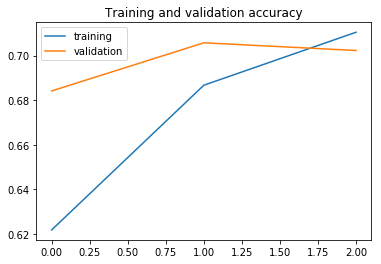

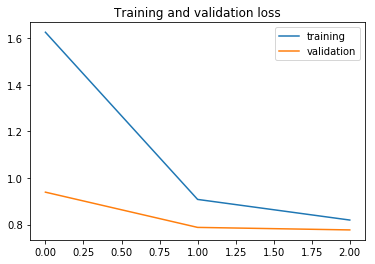

In [48]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')